In [1]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 1. Load Data & Re-Train Model (Quickly)
# (In a real app, you would load the saved model, but let's rebuild for flow)
df = pd.read_csv('../data/processed/market_features.csv', index_col=0, parse_dates=True)
df['Next_Day_Return'] = df['SPY_Log_Ret'].shift(-1)
df['Target'] = (df['Next_Day_Return'] < -0.01).astype(int)
df = df.dropna()

X = df[['SPY_Log_Ret', 'SPY_Vol_30d']] # We will add more features next week
y = df['Target']

# Train the model using the parameters we found in Week 8
model = xgb.XGBClassifier(scale_pos_weight=10, n_estimators=100, max_depth=4, eval_metric='logloss')
model.fit(X, y)

# 2. Initialize SHAP Explainer
# This object "learns" how the trees make decisions
explainer = shap.TreeExplainer(model)

# 3. Calculate SHAP Values for the entire dataset
shap_values = explainer.shap_values(X)

print("✅ SHAP Values Calculated.")
print(f"Shape of SHAP matrix: {shap_values.shape}")
# Shape should match your X (Rows, Features)

✅ SHAP Values Calculated.
Shape of SHAP matrix: (956, 2)


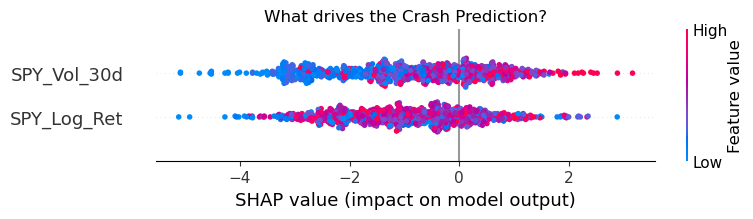

In [2]:
# Summary Plot
plt.title("What drives the Crash Prediction?")
shap.summary_plot(shap_values, X, show=False)
plt.show()

Analyzing Crash Prediction for: 2020-03-13
Actual Input Values: Volatility=0.5765, Return=0.0820


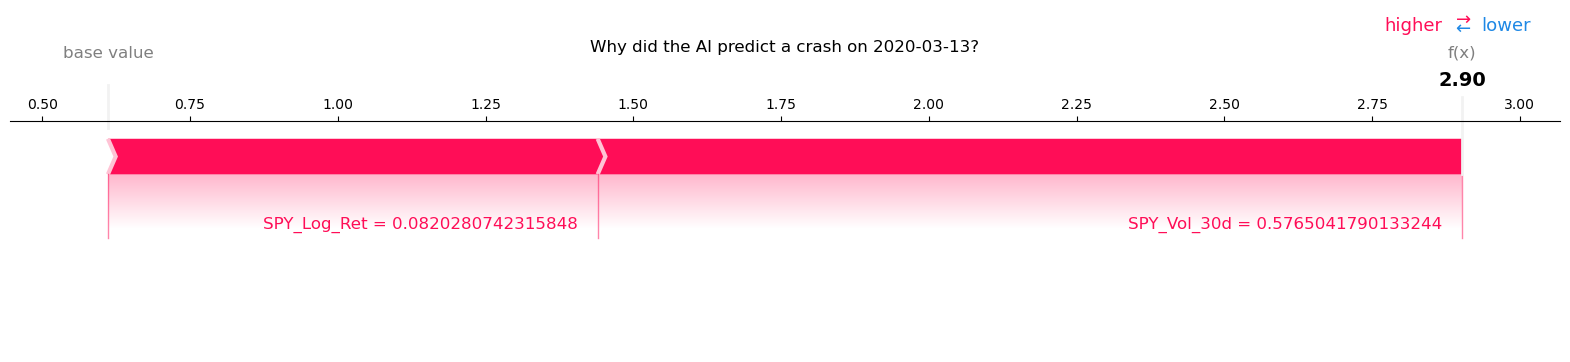

In [3]:
# 1. Find a day where the model predicted a Crash (Probability > 80%)
# Get probabilities
probs = model.predict_proba(X)[:, 1]
high_risk_indices = [i for i, p in enumerate(probs) if p > 0.8]

# Pick the first high-risk day found
if len(high_risk_indices) > 0:
    idx = high_risk_indices[0]
    date_of_crash = X.index[idx].strftime('%Y-%m-%d')
    
    print(f"Analyzing Crash Prediction for: {date_of_crash}")
    print(f"Actual Input Values: Volatility={X.iloc[idx]['SPY_Vol_30d']:.4f}, Return={X.iloc[idx]['SPY_Log_Ret']:.4f}")

    # 2. Force Plot
    # This requires Javascript, so we use matplotlib=True for static image
    shap.force_plot(
        explainer.expected_value, 
        shap_values[idx,:], 
        X.iloc[idx,:], 
        matplotlib=True,
        show=False
    )
    plt.title(f"Why did the AI predict a crash on {date_of_crash}?", pad=50)
    plt.show()
else:
    print("No high confidence crash predictions found in this subset.")